# Bonus point

# Import and read files

In [29]:
import pandas as pd
import numpy as np
import pycountry
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from nltk import wordpunct_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import defaultdict

In [30]:
import community
import networkx as nx
import matplotlib.pyplot as plt

In [146]:
from gensim import corpora, models

/home/stefano/anaconda3/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
emails = pd.read_csv('hillary-clinton-emails/sentimentEmails.csv')
emails.head()

,ExtractedBodyText,MetadataSubject,Sentiment
0,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,0.0000
1,Thx,CHRIS STEVENS,0.3612
2,"H <hrod17@clintonemail.com>\nFriday, March 11,...",H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,0.0000
3,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,MEET THE RIGHT-WING EXTREMIST BEHIND ANTI-MUSL...,-0.9191
4,"H <hrod17@clintonemail.corn>\nFriday, March 11...",H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,0.0000


In [3]:
fullDF = pd.read_csv('hillary-clinton-emails/Emails.csv')

In [4]:
fullDF.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


In [5]:
fullDF.SenderPersonId

0        87.0
1         NaN
2        32.0
3        32.0
4        80.0
5        80.0
6        32.0
7        80.0
8        87.0
9         NaN
10       87.0
11        NaN
12       87.0
13       10.0
14       32.0
15       77.0
16      213.0
17      213.0
18       87.0
19       87.0
20       80.0
21       80.0
22       80.0
23       80.0
24       87.0
25      194.0
26       87.0
27       32.0
28       21.0
29       81.0
        ...  
7915    194.0
7916     87.0
7917    148.0
7918     32.0
7919    143.0
7920     81.0
7921     32.0
7922     48.0
7923    103.0
7924     10.0
7925    180.0
7926     32.0
7927     32.0
7928     87.0
7929     32.0
7930     32.0
7931     32.0
7932     87.0
7933    194.0
7934     81.0
7935     81.0
7936     32.0
7937     32.0
7938    204.0
7939     87.0
7940    180.0
7941    180.0
7942    116.0
7943    143.0
7944     87.0
Name: SenderPersonId, dtype: float64

In [6]:
fullDF.shape

(7945, 22)

In [7]:
emails.shape

(6456, 3)

# Merge the 2 databases

In [8]:
bodyDF=fullDF[['ExtractedBodyText','MetadataSubject']]

In [9]:
reducedDF=fullDF[np.sum(bodyDF.isnull(),axis=1)==0]

In [10]:
reducedDF.shape

(6456, 22)

In [11]:
# reducedDF=reducedDF.reset_index(drop=True)
reducedDF.head(2)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...


In [12]:
reducedDF.MetadataSubject=emails.MetadataSubject
reducedDF.ExtractedBodyText=emails.ExtractedBodyText
reducedDF.head(3)

/home/stefano/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
1,2,C05739546,CHRIS STEVENS,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.corn>\nFriday, March 11...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


# Process the reduced DF

In [13]:
reducedDF.columns

Index(['Id', 'DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'],
      dtype='object')

In [35]:
finalDF=reducedDF[['Id','SenderPersonId','MetadataSubject','ExtractedBodyText']]

In [36]:
finalDF=finalDF.dropna()
finalDF=finalDF.set_index(finalDF.Id)
del finalDF['Id']
finalDF.head()

,SenderPersonId,MetadataSubject,ExtractedBodyText
Id,,,
3,32.0,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"H <hrod17@clintonemail.com>\nFriday, March 11,..."
5,80.0,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"H <hrod17@clintonemail.corn>\nFriday, March 11..."
6,80.0,SECRETARY'S REMARKS,FYI
8,80.0,ABZ AN HBJ ON LIBYA AND WEST BANK/GAZA,Fyi\nB6\n— —
9,87.0,MORE ON LIBYA,"B6\nWednesday, September 12, 2012 6:16 PM\nFwd..."


In [42]:
finalDF.loc[3].SenderPersonId

32.0

In [37]:
finalDF.shape

(5216, 3)

In [38]:
len(finalDF.SenderPersonId.value_counts())

95

# Reading EmailReceivers

In [39]:
email_receivers=pd.read_csv('hillary-clinton-emails/EmailReceivers.csv')
email_receivers=email_receivers.set_index(email_receivers.Id)
del email_receivers['Id']

In [40]:
email_receivers.head()

,EmailId,PersonId
Id,,
1,1,80
2,2,80
3,3,228
4,3,80
5,4,80


In [74]:
def add_sender(x):
    try:
        x['Sender']=finalDF.loc[x.EmailId.iloc[0]].SenderPersonId
    except:
        x['Sender']=float('nan')
    return x

In [77]:
email_receivers=email_receivers.groupby(email_receivers.EmailId).apply(add_sender)

In [86]:
email_receivers=email_receivers.dropna()
email_receivers.Sender=email_receivers.Sender.apply(lambda x: int(x))
email_receivers.head()

,EmailId,PersonId,Sender
Id,,,
3,3,228,32
4,3,80,32
6,5,81,80
7,6,185,80
9,8,81,80


In [97]:
finalDF.shape

(5216, 3)

# Trying the libraries

In [87]:
graph=nx.Graph()
for a, b in email_receivers[['Sender','PersonId']].itertuples(index=False):
    graph.add_edge(a,b)

In [89]:
partition=community.best_partition(graph)

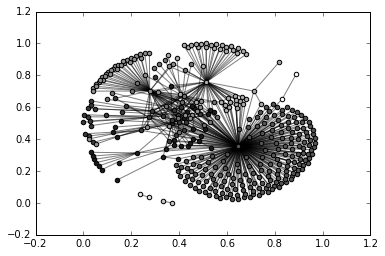

In [90]:
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(graph)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(graph, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(graph,pos, alpha=0.5)
plt.show()

# Add in finalDF a column with the community of the sender

In [113]:
def add_community(x):
    x['Community']=partition[x.SenderPersonId.iloc[0]]
    return x

In [114]:
finalDF.head(2)

,SenderPersonId,MetadataSubject,ExtractedBodyText
Id,,,
3,32.0,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"H <hrod17@clintonemail.com>\nFriday, March 11,..."
5,80.0,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"H <hrod17@clintonemail.corn>\nFriday, March 11..."


In [117]:
finalDF=finalDF.groupby(finalDF.SenderPersonId).apply(add_community)

In [118]:
finalDF.head(4)

,SenderPersonId,MetadataSubject,ExtractedBodyText,Community
Id,,,,
3,32.0,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"H <hrod17@clintonemail.com>\nFriday, March 11,...",4
5,80.0,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"H <hrod17@clintonemail.corn>\nFriday, March 11...",2
6,80.0,SECRETARY'S REMARKS,FYI,2
8,80.0,ABZ AN HBJ ON LIBYA AND WEST BANK/GAZA,Fyi\nB6\n— —,2


In [120]:
list(finalDF.MetadataSubject)

['H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MORE... SID',
 'H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MORE... SID',
 "SECRETARY'S REMARKS",
 'ABZ AN HBJ ON LIBYA AND WEST BANK/GAZA',
 'MORE ON LIBYA',
 'PIECE ON LIBYA NFZ THAT WILL APPEAR ON NYT OP-ED PAGE TOMORROW',
 'THANK YOU',
 'THE YOUTH OF LIBYA',
 'ONE MORE PHOTO',
 'S TODAY',
 'THE YOUTH OF LIBYA',
 'MORE ON LIBYA',
 'MORE ON LIBYA',
 'H: MAGARIAF ON ATTACK ON US IN LIBYA. SID',
 'H: MAGARIAF ON ATTACK ON US IN LIBYA. SID',
 'PROPOSED QUAD DEAL',
 'H: MORE MAGARIAF PRIVAT REAX (SENT NOW AS MEMO). SID',
 'MORE ON LIBYA',
 'AMB STEVENS ',
 'CNN BELIEF BLOG. PROTHERO',
 'CHRIS STEVENS MISSION',
 'QUICK SUMMARY OF POTUS CALLS TO PRESIDENTS OF LIBYA AND EGYPT',
 'WASH POST: HILLARY CLINTON TRIES TO CALM ANTI-U.S. SENTIMENT AS PROTESTERS STORM EMBASSY IN YEMEN',
 'H: LOTS OF NEW INTEL; POSSIBLE LIBYAN COLLAPSE. SID',
 'QUICK SUMMARY OF POTUS CALLS TO PRESIDENTS OF LIBYA AND EGYPT',
 'CONDOLENCES FROM PM NETANYAHU',
 'SITUATION REPO

In [130]:
categories_list=list(set(partition.values()))

In [163]:
for cat in categories_list:
    df_community=finalDF[finalDF.Community==cat]
    text_string=' '.join(list(df_community.MetadataSubject)+list(df_community.ExtractedBodyText)).lower().split(' ')
    
    dictionary = corpora.Dictionary([text_string])
    corpus = [dictionary.doc2bow(text) for text in [text_string]]

In [164]:
len(text_string)

581

In [165]:
corpus

[[(0, 1),
  (1, 1),
  (2, 2),
  (3, 1),
  (4, 19),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 4),
  (17, 9),
  (18, 1),
  (19, 2),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 3),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 2),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 3),
  (42, 1),
  (43, 7),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 2),
  (54, 1),
  (55, 5),
  (56, 1),
  (57, 1),
  (58, 2),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 2),
  (66, 2),
  (67, 1),
  (68, 2),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 2),
  (77, 4),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 1

In [166]:
no_topics = 10
lda = models.ldamodel.LdaModel(corpus, id2word = dictionary, num_topics=no_topics)
lda.show_topics()

[(0,
  '0.007*"the" + 0.006*"and" + 0.005*"in" + 0.005*"to" + 0.005*"a" + 0.005*"of" + 0.004*"reidel" + 0.004*"with" + 0.004*"is" + 0.004*"for"'),
 (1,
  '0.007*"the" + 0.006*"and" + 0.006*"in" + 0.005*"to" + 0.005*"a" + 0.005*"of" + 0.004*"with" + 0.004*"on" + 0.004*"for" + 0.004*"—"'),
 (2,
  '0.014*"the" + 0.010*"in" + 0.009*"a" + 0.008*"to" + 0.007*"and" + 0.006*"of" + 0.006*"report" + 0.006*"is" + 0.005*"with" + 0.005*"reidel"'),
 (3,
  '0.027*"the" + 0.013*"to" + 0.012*"a" + 0.012*"and" + 0.011*"in" + 0.010*"of" + 0.009*"reidel" + 0.008*"report" + 0.008*"on" + 0.007*"—"'),
 (4,
  '0.032*"the" + 0.018*"in" + 0.015*"a" + 0.015*"and" + 0.013*"to" + 0.010*"with" + 0.010*"reidel" + 0.010*"of" + 0.009*"report" + 0.009*"is"'),
 (5,
  '0.043*"the" + 0.033*"and" + 0.032*"to" + 0.026*"in" + 0.026*"a" + 0.018*"of" + 0.016*"with" + 0.013*"reidel" + 0.013*"is" + 0.011*"for"'),
 (6,
  '0.042*"the" + 0.031*"and" + 0.024*"to" + 0.022*"a" + 0.018*"in" + 0.015*"of" + 0.014*"is" + 0.013*"reidel" + 